# Gaussian Mixture Model (GMM) and Expectation Maximization Algorithm (EM)

In this excercise we want to implement the EM algorithm for a GMM distribution.
The GMM distribution is defined as:
\begin{align}
    p(\mathbf{x}) &= \sum_{k=1}^{K} Pr(\omega_k) p(\mathbf{x} | \omega_k) \\
    &= \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}; \mu_k, \Sigma_k)
\end{align}
where $\mathbf{x}$ is a vector with $D$ entries.

Your task is to implement the E-Step and M-Step for the GMM Model.

A skeleton for the code is already prepared.

Questions:
 - The GMM is a sum of densities and not of the random variables (RV).
   What is the density of $\mathbf{x}_3 = \mathbf{x}_1 + \mathbf{x}_2$ called,
   when $\mathbf{x}_1$ and $\mathbf{x}_2$ are independent and sampled from a multivariate normal distributions?


**Answer:**
Let $\mathbf{x}_1 \sim \mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$ and $\mathbf{x}_2 \sim \mathcal{N}(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$ be two independent $d$-dimensional multivariate normal random variables.

The sum $\mathbf{x}_3 = \mathbf{x}_1 + \mathbf{x}_2$ follows a multivariate normal distribution:

$$\mathbf{x}_3 \sim \mathcal{N}(\boldsymbol{\mu}_1 + \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_1 + \boldsymbol{\Sigma}_2)$$

This is different from a Gaussian Mixture Model (GMM), which is a weighted sum of probability density functions (not random variables):

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where:

$\pi_k$ are the mixing coefficients ($\sum_{k=1}^K \pi_k = 1$, $\pi_k \geq 0$)
$\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ are the component Gaussian densities
$K$ is the number of components in the mixture
Key differences:

The sum of normals results in a single normal distribution
A GMM is a mixture (weighted sum) of density functions, not a sum of random variables
The GMM can model more complex, multi-modal distributions than a single Gaussian

In [1]:
%matplotlib inline

from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np

import pandas as pd
import seaborn as sns

import sklearn.datasets
import sklearn.model_selection
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Change the representer for large numpy arrays
def string_function(a):
    if a.size < 50:
        return str(a)
    else:
        return f'array(shape={a.shape}, dtype={a.dtype})'
np.set_string_function(string_function)

In [2]:
CMAP = 'Set1'
N_CMAP = 8

# Helpers
Briefly have a look at these helper functions and try to understand what they are doing

In [3]:
def generate_data(classes, samples_per_class, class_sep=1.0):
    """
    Generate a synthetic 2D classification dataset and split it into training and test sets.

    This function creates a synthetic dataset with specified number of classes and samples,
    where each class forms a cluster in 2D space. The data is suitable for testing and
    visualizing classification and clustering algorithms.

    Parameters
    ----------
    classes : int
        Number of classes to generate in the dataset.
    samples_per_class : int
        Total number of samples to generate across all classes.
    class_sep : float, default=1.0
        The factor to control the separation between classes. Higher values result
        in more separated clusters.

    Returns
    -------
    dict
        A nested dictionary containing the training and test sets with their
        corresponding features and labels:
        {
            'train': {
                'x': ndarray of shape (n_train_samples, 2)
                    Training samples.
                'label': ndarray of shape (n_train_samples,)
                    Training labels.
            },
            'test': {
                'x': ndarray of shape (n_test_samples, 2)
                    Test samples.
                'label': ndarray of shape (n_test_samples,)
                    Test labels.
            }
        }
        where n_train_samples + n_test_samples = samples_per_class.

    Notes
    -----
    - Uses scikit-learn's make_classification with fixed random seed for reproducibility.
    - Data is split into 75% training and 25% test sets by default.
    - Generates 2D feature space (n_features=2) with informative features.
    - Includes minimal label noise (flip_y=0.01) to simulate real-world data.

    Examples
    --------
    >>> data = generate_data(classes=3, samples_per_class=100, class_sep=1.5)
    >>> train_x = data['train']['x']  # Training features
    >>> train_y = data['train']['label']  # Training labels
    >>> test_x = data['test']['x']  # Test features
    >>> test_y = data['test']['label']  # Test labels
    """
    np.random.seed(0)
    d, labels = sklearn.datasets.make_classification(
        n_samples=samples_per_class, n_features=2, n_informative=2, n_redundant=0,
        n_repeated=0, n_classes=classes, n_clusters_per_class=1, weights=None, flip_y=0.01,
        class_sep=class_sep, hypercube=True, shift=0.0, scale=1.0, shuffle=True)
    data = dict()
    tr_x, test_x, tr_label, test_label = \
        sklearn.model_selection.train_test_split(d, labels)
    return {'train': {'x': tr_x, 'label': tr_label}, 'test': {'x': test_x, 'label': test_label}}

In [4]:
def scatterplot(x, y, hue, data, ax=None):
    """
    Create a scatter plot with consistent hue ordering.

    This is a wrapper around seaborn's scatterplot that ensures consistent
    color mapping by enforcing a sorted order of hue values.

    Parameters
    ----------
    x, y : str
        Names of variables in `data` for x and y axes.
    hue : str
        Variable in `data` to map plot aspects to different colors.
    data : DataFrame
        Input data structure (e.g., pandas DataFrame).
    ax : matplotlib.axes.Axes, optional
        Axes object to draw the plot onto, otherwise uses the current Axes.

    Returns
    -------
    matplotlib.axes.Axes
        The Axes object with the plot drawn onto it.

    Notes
    -----
    - Uses a predefined colormap (CMAP) for consistent coloring.
    - Sorts hue values to maintain consistent color mapping across plots.
    - Wraps seaborn.scatterplot() with fixed parameters for this notebook's style.
    """
    # Calculate hue_order to prevent random legend order.
    # Insert the colormap
    hue_order = list(sorted(set(data[hue])))
    return sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=CMAP, ax=ax, hue_order=hue_order)

In [5]:
def _set_alpha(rgba, alpha):
    """
    Set the alpha (transparency) value of an RGBA color tuple.
    
    Parameters
    ----------
    rgba : tuple
        Input color as (R,G,B) or (R,G,B,A) tuple with values in [0,1].
    alpha : float
        New alpha value to set, in range [0,1].
        
    Returns
    -------
    tuple
        New color tuple with updated alpha.
        
    Raises
    ------
    ValueError
        If input rgba has invalid length (not 3 or 4).
    """
    rgba_ = list(rgba)
    if len(rgba_) == 3:
        rgba_.append(alpha)
    elif len(rgba_) == 4:
        rgba_[-1] = alpha
    else:
        raise ValueError(rgba_)
    return tuple(rgba_)

def get_component_cmap(c, N, alpha=1.):
    """
    Create a colormap for a single GMM component with specified transparency.

    Parameters
    ----------
    c : float
        Position in the colormap (0 to 1) to sample the base color.
    N : int
        Number of color segments (unused in current implementation).
    alpha : float, default=1.0
        Maximum alpha (opacity) value, range [0, 1].

    Returns
    -------
    LinearSegmentedColormap
        A colormap transitioning from transparent to the specified color with given alpha.

    Notes
    -----
    - Uses the global CMAP for base colors.
    - Creates a two-color gradient: [transparent, color_with_alpha]
    - The N parameter is accepted but not currently used.
    """
    cmap = plt.get_cmap(CMAP)
    # c *= int(N_CMAP / (N-1))  # for numeric data
    return LinearSegmentedColormap.from_list('test', [_set_alpha(cmap(c), 0), _set_alpha(cmap(c), alpha)])

def plot_prediction(estimator, density='pi * p(x|omega)'):
    """
    Visualize GMM predictions and compare with true labels.

    Creates a 2x1 subplot showing:
    1. True class labels
    2. Predicted class labels with decision boundaries

    Parameters
    ----------
    estimator : GMM
        Fitted Gaussian Mixture Model instance.
    density : {'pi * p(x|omega)', 'p(omega|x)'}, default='pi * p(x|omega)'
        Type of density to plot:
        - 'pi * p(x|omega)': Component densities weighted by mixing coefficients
        - 'p(omega|x)': Posterior probabilities (responsibilities)

    Returns
    -------
    None
        Displays a matplotlib figure with the visualization.

    Notes
    -----
    - Uses global 'data' variable containing test data
    - Left subplot shows true labels
    - Right subplot shows predictions with colored decision regions
    - Misclassified points are marked in the right subplot
    """
    n_classes = estimator.n_components
    pred_labels = estimator.predict(data['test']['x'])  
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    df = pd.DataFrame({
        '$x_1$': data['test']['x'][:, 0],
        '$x_2$': data['test']['x'][:, 1],
        'pred_label': [f'k={l}' for l in pred_labels],
        'true_label': [f'k={l}' for l in data['test']['label']],
        'classified': [
            'correct' if true_label == pred_label else 'wrong'
            for true_label, pred_label in zip(data['test']['label'], pred_labels)
        ]
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax1)
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='pred_label', ax=ax2)
    
    x_min, x_max = np.min(data['test']['x'][:, 0]), np.max(data['test']['x'][:, 0])
    y_min, y_max = np.min(data['test']['x'][:, 1]), np.max(data['test']['x'][:, 1])
    X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    if density == 'pi * p(x|omega)':
        Z = np.exp(estimator._estimate_log_prob(np.vstack((X.flatten(), Y.flatten())).T))
    elif density == 'p(omega|x)':
        Z = estimator.predict_proba(np.vstack((X.flatten(), Y.flatten())).T)
    else:
        raise ValueError(density)

    for c in range(n_classes):
        alpha = estimator.weights_[c]
        if density == 'p(omega|x)':
            alpha = 1 / n_classes
        ax2.contourf(X, Y, Z[:, c].reshape(X.shape), cmap=get_component_cmap(c, n_classes, alpha))

In [6]:
def plot_data(data):
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    
    df = pd.DataFrame({
        '$x_1$': data['train']['x'][:, 0],
        '$x_2$': data['train']['x'][:, 1],
        'true_label': [f'k={l}' for l in data['train']['label']],
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax1)
    ax1.set_title('train data')
    ax1.grid()
    df = pd.DataFrame({
        '$x_1$': data['test']['x'][:, 0],
        '$x_2$': data['test']['x'][:, 1],
        'true_label': [f'k={l}' for l in data['test']['label']],
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax2)
    ax2.set_title('test data')
    ax2.grid()

# Gaussian data

In [7]:
data = generate_data(3, 1000)

In [8]:
data

{'train': {'x': array(shape=(750, 2), dtype=float64),
  'label': array(shape=(750,), dtype=int32)},
 'test': {'x': array(shape=(250, 2), dtype=float64),
  'label': array(shape=(250,), dtype=int32)}}

In [9]:
data['train']['label']

array(shape=(750,), dtype=int32)

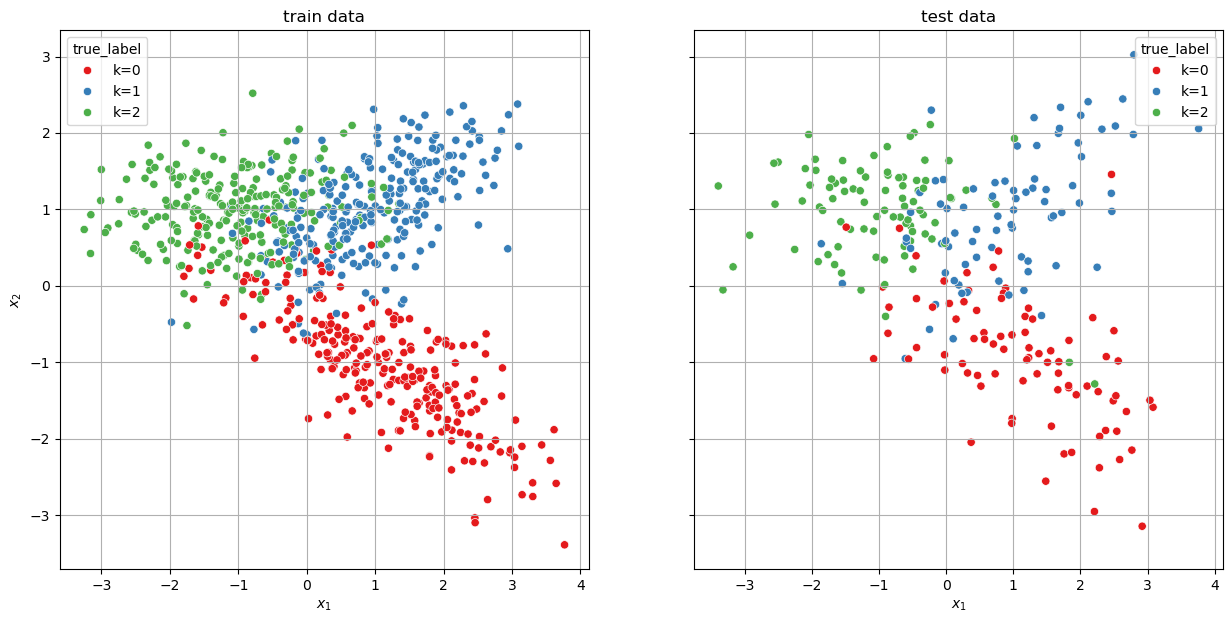

In [10]:
plot_data(data)
plt.show()

# Calculate the mean for each class to use it as an oracle initialization later

In [11]:
means_init = np.array([data['train']['x'][data['train']['label'] == l].mean(axis=0) for l in range(3)])
means_init

[[ 1.09229366 -1.03883468]
 [ 0.94413485  1.03711168]
 [-1.05007624  0.97929807]]

# Write your own GMM class

Use the skeleton below to write your own GMM which can be fitted to the data with the EM-Algorithm

In [12]:
class GMM:
    def __init__(self, n_components=3, tol=0.001, max_iter=100,
                 means_init=None):
        self.n_components = n_components  # number of clusters
        self.tol = tol  # threshold to stop
        self.max_iter = max_iter  # maximum number of iterations
        self.means_init = means_init
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihoods = None

    @staticmethod
    def _calculate_probabilities_for_gaussian(X, mu, sigma):
        """
        Calculate the probabilities N(x; mu, sigma)
        for each datapoint in X given the parameters mu and sigma

        Args:
            X: datapoints of shape [n_datapoints, n_dims]
            mu_k: mean vector of shape [n_dims]
            sigma_k: covariance matrix of shape [n_dims, n_dims]
            #exp( -0.5 (x_n-u_k)^T S_k^-1 (x_n-u_k) )
        Return: (output)
            probabilities for each datapoint [n_datapoints]
        """
        x_centered = X - mu
        exponent = np.einsum(  
            'nd,dD,nD -> n',  
            x_centered,  
            np.linalg.inv(sigma),  
            x_centered,  
        )  
        exponent *= -.5  
        return (   
                np.linalg.det(sigma) ** -.5 *  
                (2 * np.pi) ** (-X.shape[1] / 2.)  
                * np.exp(exponent)  
        )  
    
    def _estimate_log_prob(self, X):
        """
        Calculate the log-probabilities log(p(x|omega)) for each component.

        Args:
            X: datapoints of shape [n_datapoints, n_dims]

        Return:
            log_probabilities: probabilities for each datapoint [n_datapoints, n_components]
        """
        return np.log([ 
            self._calculate_probabilities_for_gaussian(X, mu, sigma)  
            for mu, sigma in zip(self.means, self.covariances)  
        ]).T  
    
    def _estimate_weighted_log_prob(self, X):
        """
        Calculate the weighted log-probabilities, log(p(x|omega)) + log(pi).

        Args:
            X: datapoints of shape [n_datapoints, n_dims]

        Return:
            weighted_log_probabilities: probabilities for each datapoint [n_datapoints, n_components]
        """
        return self._estimate_log_prob(X) + np.log(self.weights) 

    def fit(self, X):

        n_datapoints, n_dims = X.shape

        if self.means_init is None:
            # randomly choose the starting centroids/means
            # as `self.n_components` of the points from datasets
            mu = X[np.random.choice(X.shape[0], self.n_components, False), :] 
        else:
            mu = self.means_init

        # initialize the covariance matrices for each Gaussians as
        # an identity matrix. I.e. sigma should be a list with
        # identity matrices of appropriate dimension
        sigma = [np.eye(n_dims)] * self.n_components  

        # initialize the probabilities/weights for each gaussians
        # with uniform probability
        weights = [1. / self.n_components] * self.n_components  

        # log_likelihoods
        log_likelihoods = []

        # Iterate till max_iters iterations
        for _ in range(self.max_iter):

            # E - Step

            # Create a [n_datapoints, n_components] matrix with the probability
            # for each observation for each component: pi_k * N(x_n; mu_k, sigma_k)
            responsibility_matrix = list()
            for k in range(self.n_components):
                responsibility_matrix.append(   
                    weights[k] * self._calculate_probabilities_for_gaussian(X, mu[k], sigma[k]))  
            responsibility_matrix = np.stack(responsibility_matrix, axis=1)  

            # Normalize so that the responsibility matrix is row stochastic
            responsibility_matrix /= np.sum(responsibility_matrix, axis=1,  
                                            keepdims=True)  
            
            # Likelihood computation
            log_likelihood = np.sum(
                np.log(np.sum(responsibility_matrix, axis=1)))
            log_likelihoods.append(log_likelihood)
            
            
            # The effective number of datapoints belonging to each gaussian.
            # Calculated by summing over the posterior.
            N_ks = np.sum(responsibility_matrix, axis=0)  

            # M - Step for each component
            for k in range(self.n_components):
                # mean vector
                mu[k] = 1. / N_ks[k] * np.einsum('N,ND->D', responsibility_matrix[:, k], X)  
                x_mu = X - mu[k]  

                # covariance matrix
                sigma[k] = (  
                    1 / N_ks[k]  
                    * np.einsum('Nd,N,ND->dD', x_mu, responsibility_matrix[:, k], x_mu)  # REPLACE
                )  

                # weight vector
                weights[k] = N_ks[k] / n_datapoints  
            # check for convergence
            if len(log_likelihoods) >= 2:
                if np.abs(log_likelihood - log_likelihoods[-2]) < self.tol:
                    break

        # Set the new parameters
        self.means = mu
        self.means_ = mu  # for API compatibility with sklearn
        self.covariances = sigma
        self.covariances_ = sigma  # for API compatibility with sklearn
        self.weights = weights
        self.weights_ = weights  # for API compatibility with sklearn
        self.log_likelihoods = log_likelihoods

    def predict(self, X):
        """
        Predicts the class affinities for each datapoint.

        Args:
            X: datapoints of size [n_datapoints, n_dims]
        Returns:
            A vector of size [n_datapoints] with the index of the most
            likely component associated with each datapoint
        """
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        """
        Predicts the posterior probabilities for each datapoint for each component.

        Args:
            X: datapoints of size [n_datapoints, n_dims]
        Returns:
            A [n_datapoints, n_components] matrix with the probabilities
            for each datapoint for each component
        """
        proba = np.exp(self._estimate_weighted_log_prob(X))  
        proba /= np.sum(proba, axis=-1, keepdims=True)  
        return proba  

In [13]:
N = 10
D = 2

mu = np.ones(D)
X = np.ones([N,D])
sigma = np.eye(D)

In [14]:
mu

[1. 1.]

In [15]:
X

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]

In [16]:
sigma

[[1. 0.]
 [0. 1.]]

In [17]:
# (x_n - u_k)
assert mu.shape == (2, ), mu.shape
assert mu[:, np.newaxis].shape == (D, 1), mu.shape

In [18]:
X_meanfree = (X - mu[np.newaxis,:])
X_meanfree

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

In [19]:
# S_k^-1
sigma_inv = np.linalg.inv(sigma)
sigma_inv

[[1. 0.]
 [0. 1.]]

In [20]:
# (x_n-u_k)^T S_k^-1 (x_n-u_k)
print(X_meanfree.shape, sigma_inv.shape, X_meanfree.T.shape)
X_meanfree @ sigma_inv @ X_meanfree.T

(10, 2) (2, 2) (2, 10)


array(shape=(10, 10), dtype=float64)

In [21]:
exponent = np.einsum(  # REPLACE exponent = ???  # x_n.T @ sigma @ x_n
            'nd,dD,nD -> n',  # REPLACE
            X_meanfree,  # REPLACE
            np.linalg.inv(sigma),  # REPLACE
            X_meanfree,  # REPLACE
        )  
exponent

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [22]:
def get_fitted_estimator(n_classes, means_init=None):
    estimator = GMM(means_init=means_init)
    estimator.fit(data['train']['x'])
    return estimator

## Fit a GMM estimator
 - Why are the predicted label sometimes swapped?
 - What is the difference between the two density option for the plot function?
   - Can you explain what they show?

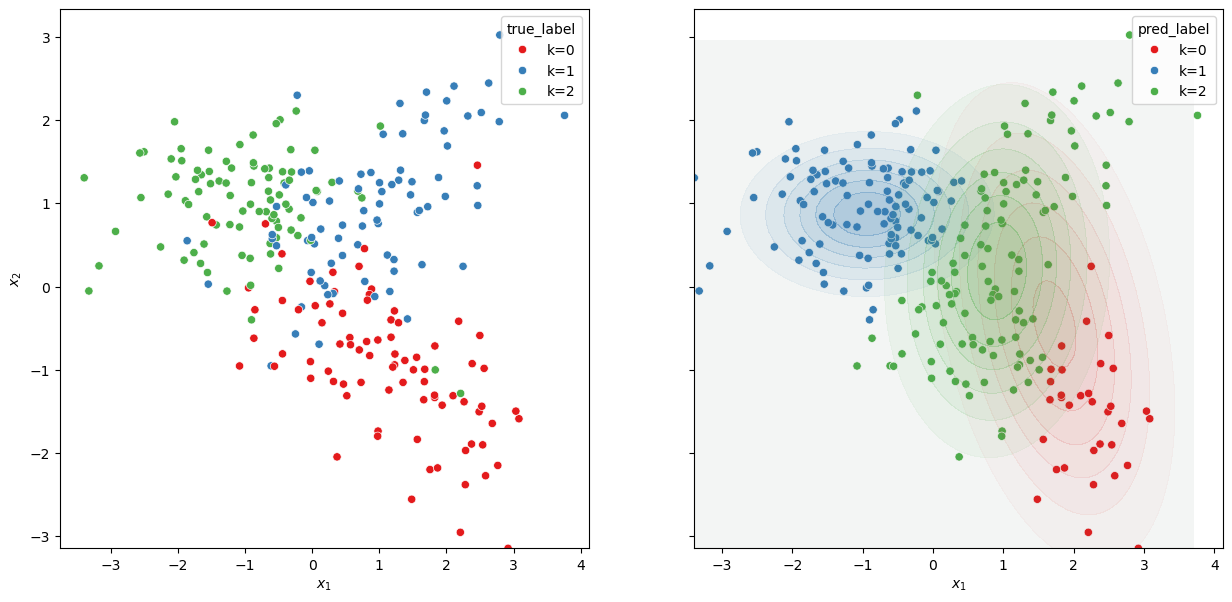

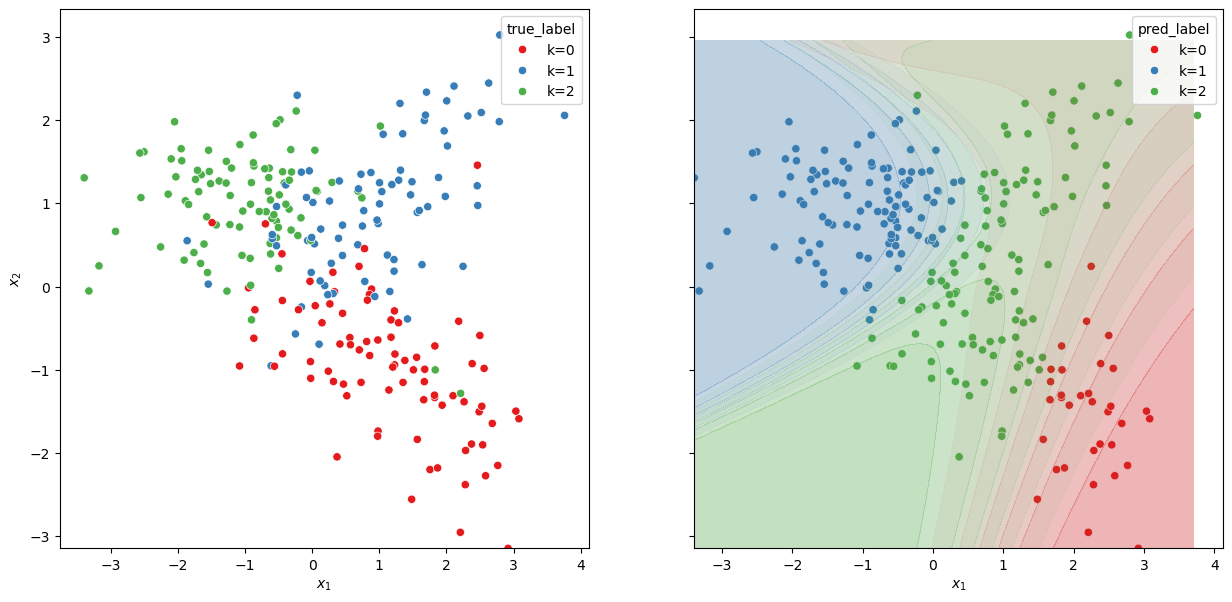

In [23]:
estimator = get_fitted_estimator(3, None) #Randomly initialized mean
plot_prediction(estimator, density='pi * p(x|omega)')
plot_prediction(estimator, density='p(omega|x)')
plt.show()

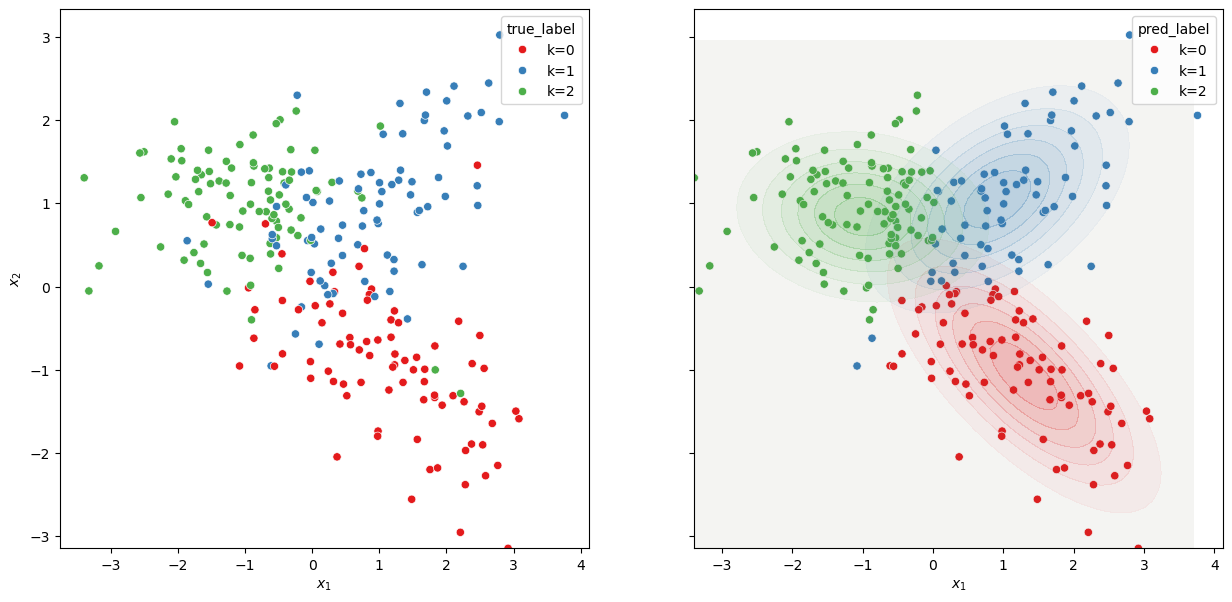

In [24]:
plot_prediction(get_fitted_estimator(3, means_init)) # using initialized mean
plt.show()

## Score the estimation

One way to score the estimation is to calculate the accuracy.
To calculate the accuracy we need to know if each datapoint is classified correct or wrong.

The function `plot_prediction` defines `classified` for the `pd.DataFrame`.
This can be used as alternative visualisation of the `pred_label` or `true_label`.

 - Change the souce code of `plot_prediction` to show 3 plots.
 - The third plot should show if a point is `correct` or `wrong` `classified`.
 - Try to observe the following when you execute `plot_prediction(get_fitted_estimator(3))`:
    - Most samples are `correct` classified
    - Most samples are `wrong` classified
 - Do you have an idea, what is wrong in the calculation of `classified`?
 - Can you fix it?

# SKlearn

Instead of writing our own code , we can also use an available package, in this case `sklearn`.
Take a look at the `sklearn.mixture` module and especially the class `GaussianMixture`.
Complete the function below and explore the parameter options.

In [25]:
def get_fitted_estimator_sklearn(
        data,
        n_classes,
        covariance_type,
        means_init=None,
        init_params='kmeans',
        max_iter=100,
        tol=0.001,  # REPLACE
):
    estimator = GaussianMixture(  # REPLACE estimator = ???
        n_components=n_classes,  # REPLACE
        covariance_type=covariance_type,  # REPLACE
        init_params=init_params,  # REPLACE
        max_iter=max_iter,  # REPLACE
        tol=tol,  # REPLACE
        means_init=means_init)  # REPLACE
    estimator.fit(data['train']['x'])
    return estimator

### Predictions with same number of classes

### Random initialization

In [26]:
estimator = get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='random', max_iter=100)
estimator

GaussianMixture(covariance_type='diag', init_params='random', n_components=3)

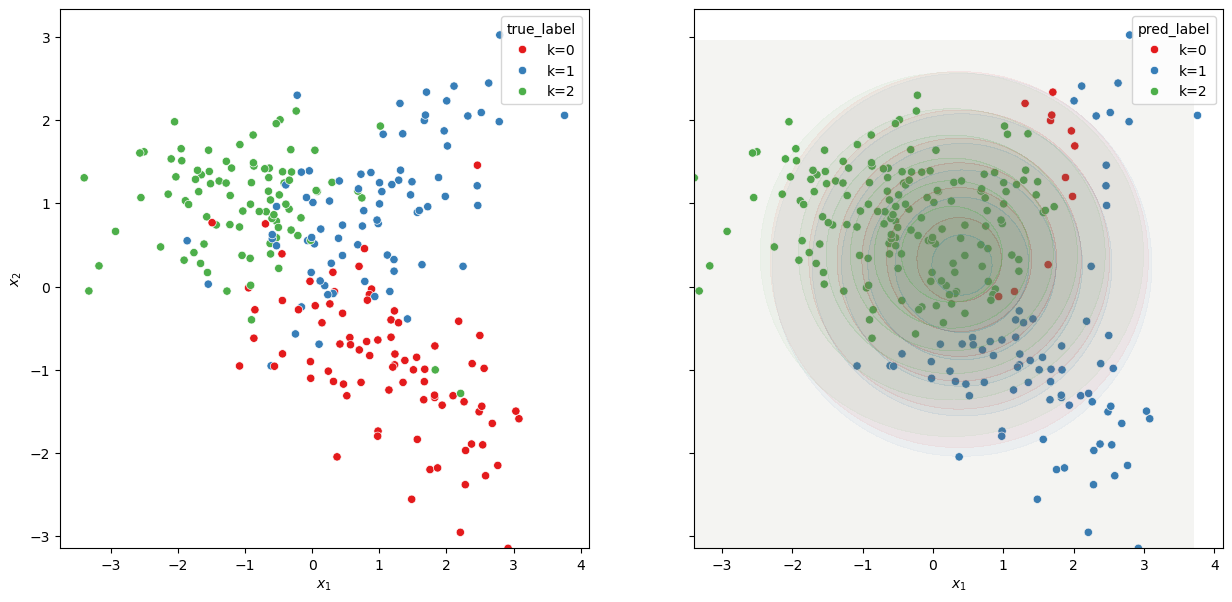

In [27]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='random', max_iter=100))
plt.show()

### Initialize mean with training data

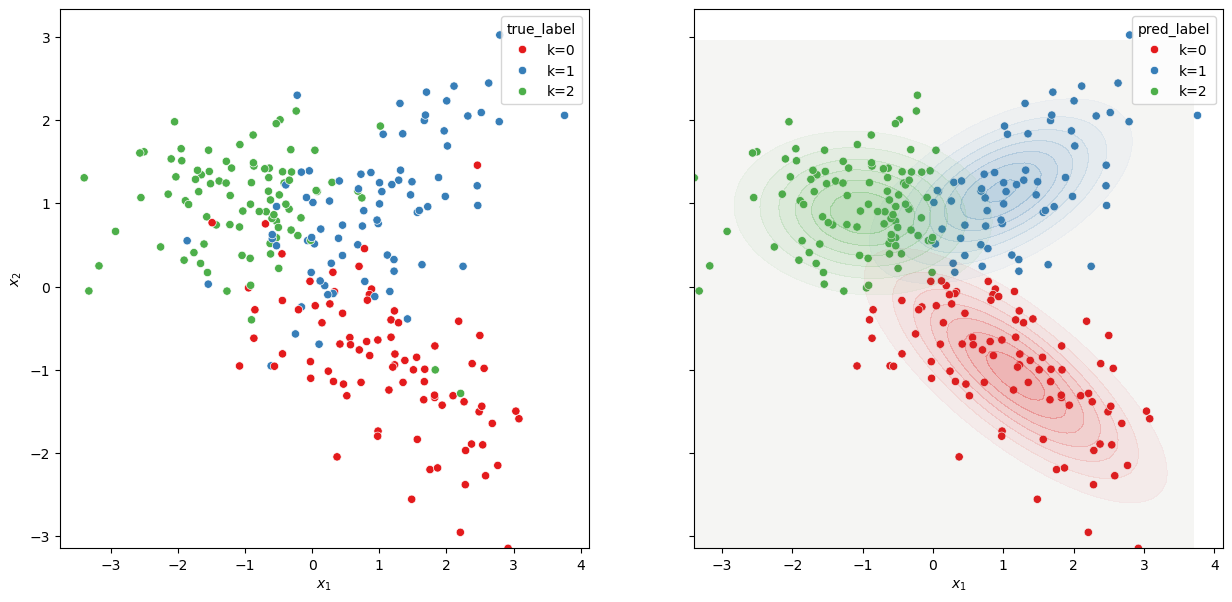

In [28]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'full', means_init=means_init, init_params='random'))
plt.show()

**Try to adjust the number of iterations. Is it possible to get an equally good result with random initialization? What is the advantage of the random initialization?**

### Now try out `kmeans` initialization

c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


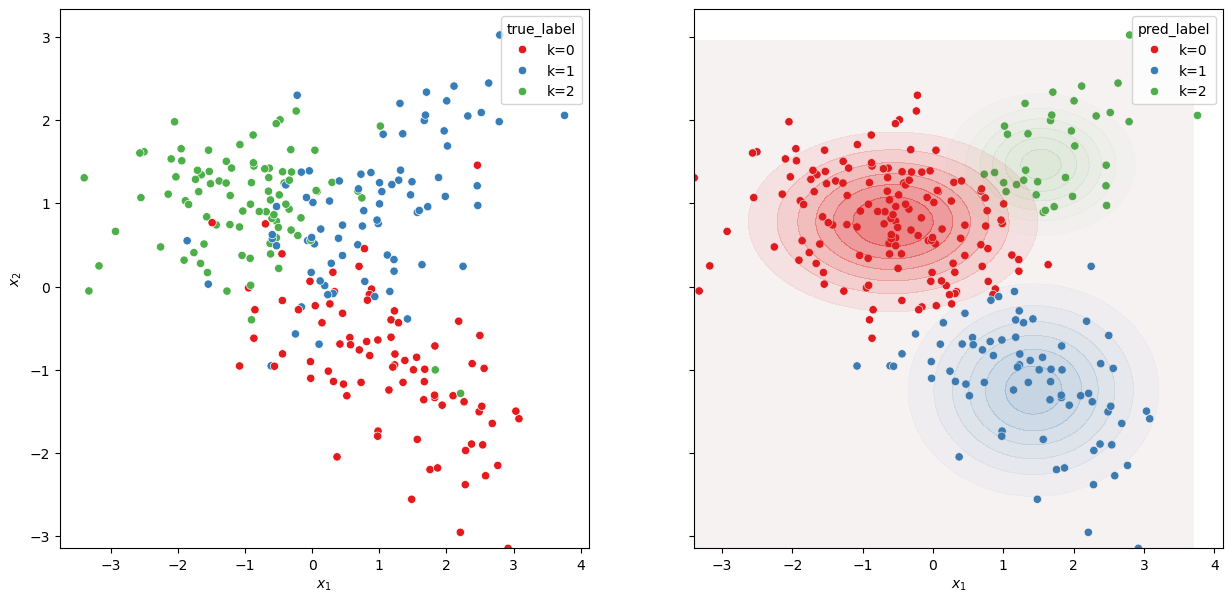

In [29]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='kmeans'))
plt.show()

**How does it work? Explain why the colors do not match. What are the (dis)advantages of the kmeans initialization?**

## Predictions with different number of classes

c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


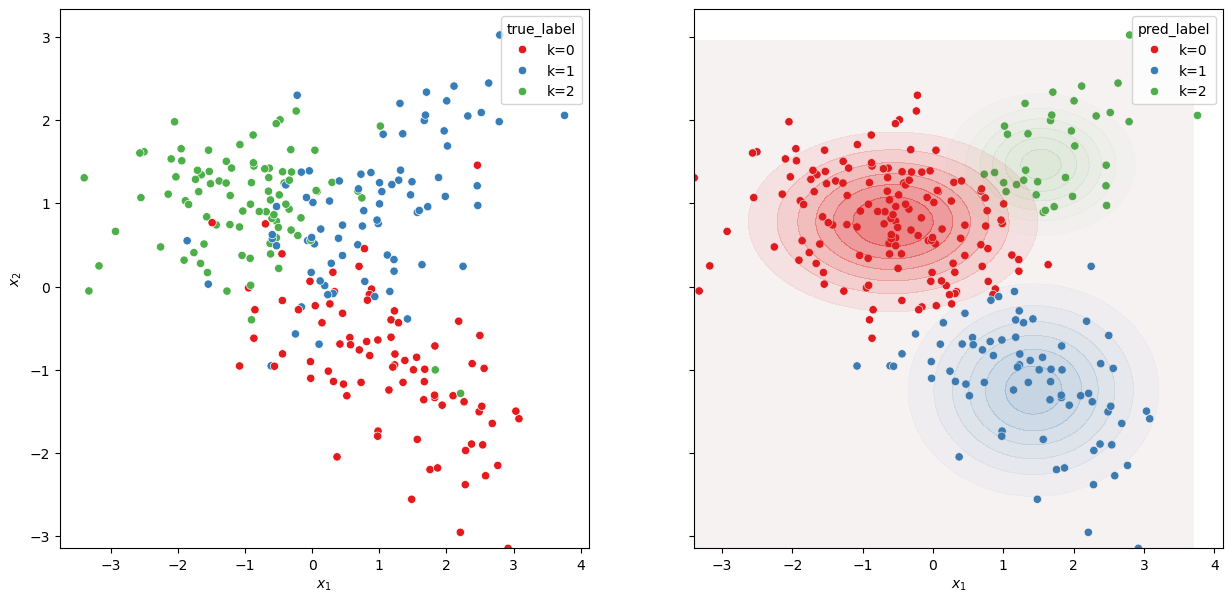

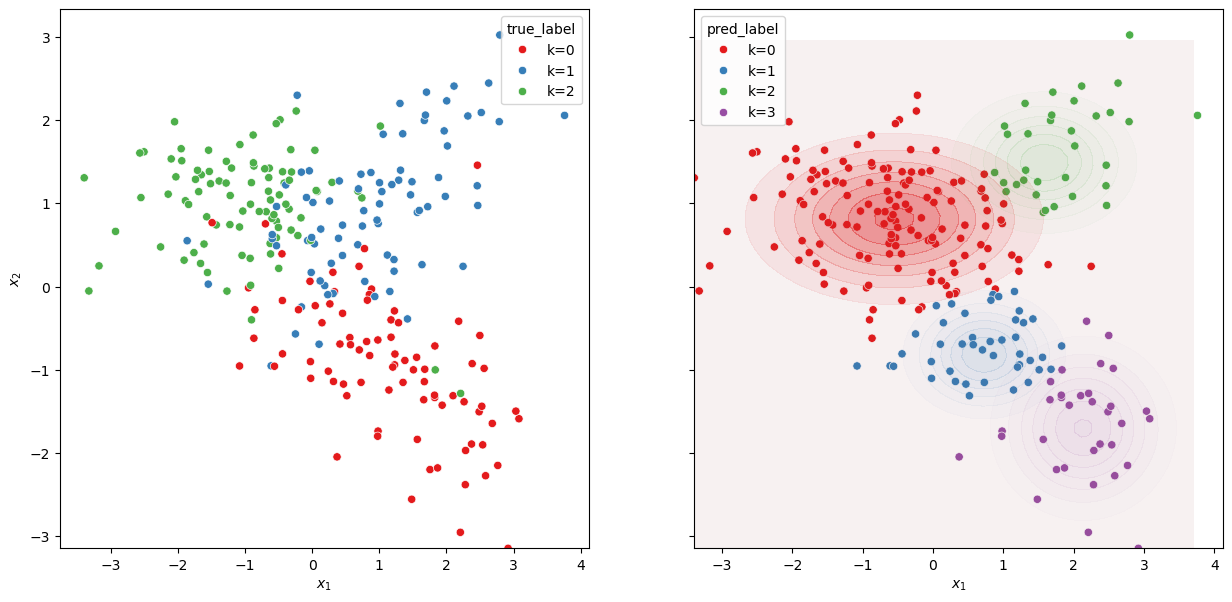

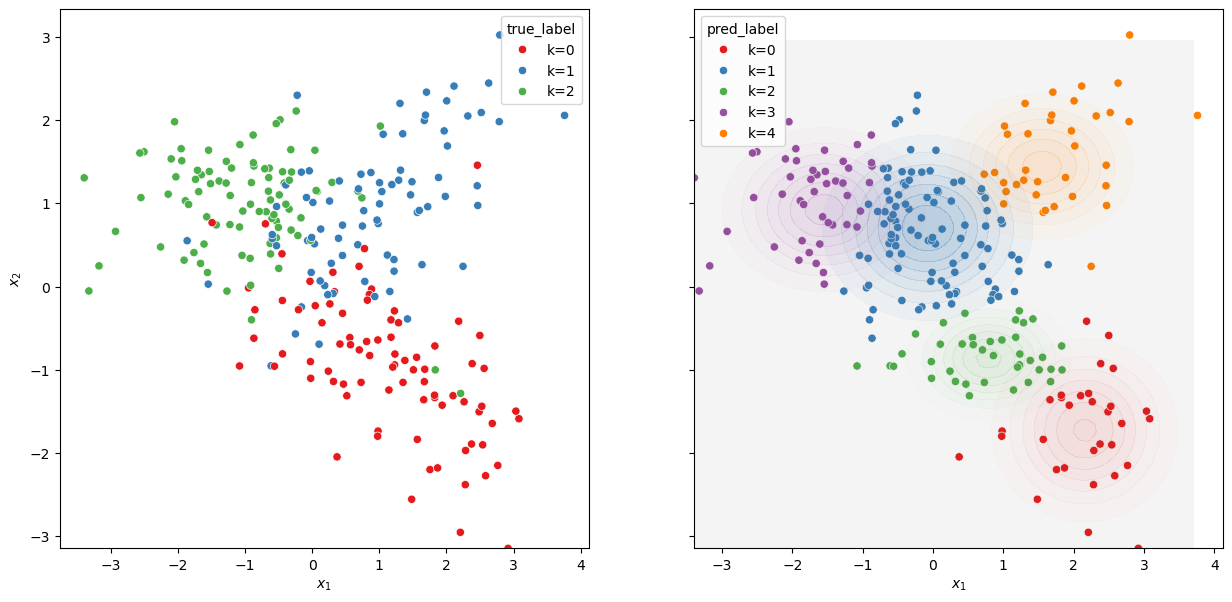

In [30]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='kmeans'))
plot_prediction(get_fitted_estimator_sklearn(data, 4, 'diag', means_init=None, init_params='kmeans'))
plot_prediction(get_fitted_estimator_sklearn(data, 5, 'diag', means_init=None, init_params='kmeans'))
plt.show()

**What is the best segmentation? How would you choose the number of classes?**

## Bayesian GMM

In [31]:
BayesianGaussianMixture?

Init signature:
BayesianGaussianMixture(
    *,
    n_components=1,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10,
)
Docstring:     
Variational Bayesian estimation of a Gaussian mixture.

This class allows to infer an approximate posterior distribution over the
parameters of a Gaussian mixture distribution. The effective number of
components can be inferred from the data.

This class implements two types of prior for the weights distribution: a
finite mixture model with Dirichlet distribution and an infinite mixture
model with the Dirichlet Process. In practice Dirichlet Process inference
algorithm is approximated and uses 

In [32]:
def get_fitted_bayesian_estimator(data, n_classes, covariance_type, max_iter, weight_concentration_prior, init_params='kmeans', random_state=0):
    estimator = BayesianGaussianMixture(
        n_components=n_classes, covariance_type=covariance_type,  # REPLACE ???
        weight_concentration_prior=weight_concentration_prior,  # REPLACE
        init_params=init_params,   # REPLACE
        max_iter=max_iter, random_state=random_state  # REPLACE
    )
    estimator.fit(data['train']['x'])
    return estimator

In [33]:
data = generate_data(3, 1000)

#### Different number of EM iterations

c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Saad\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or incre

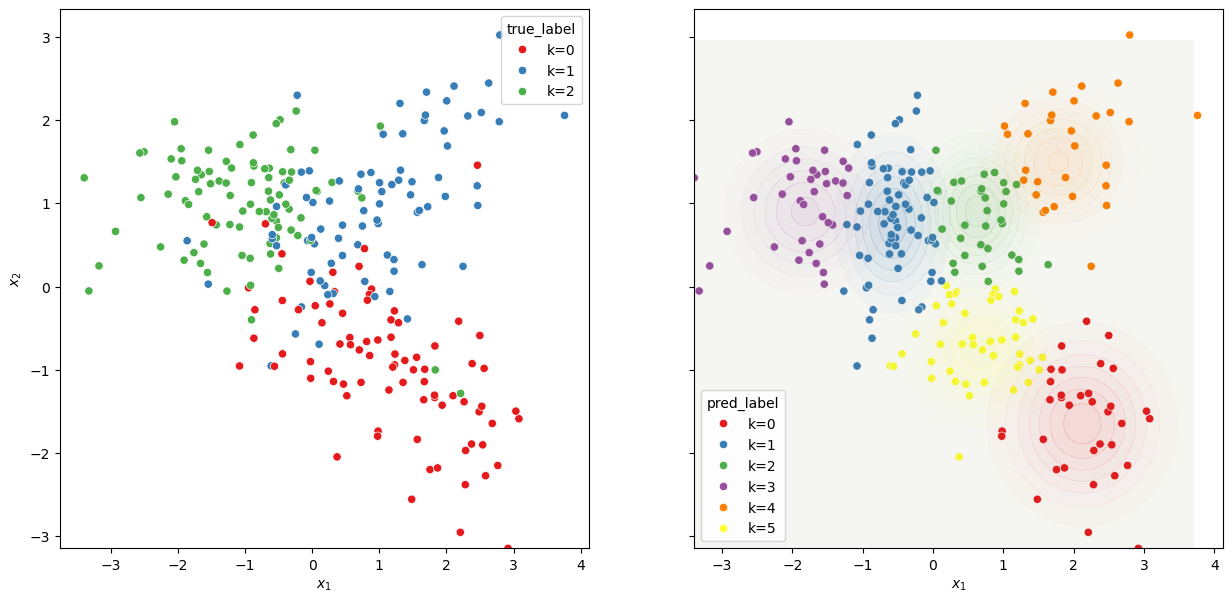

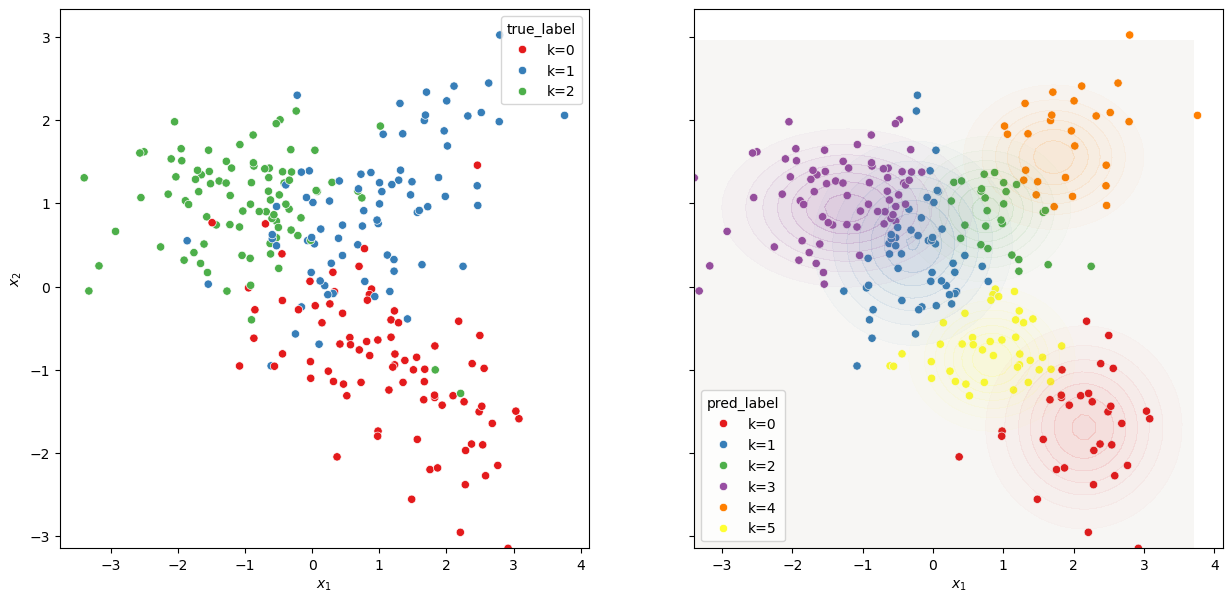

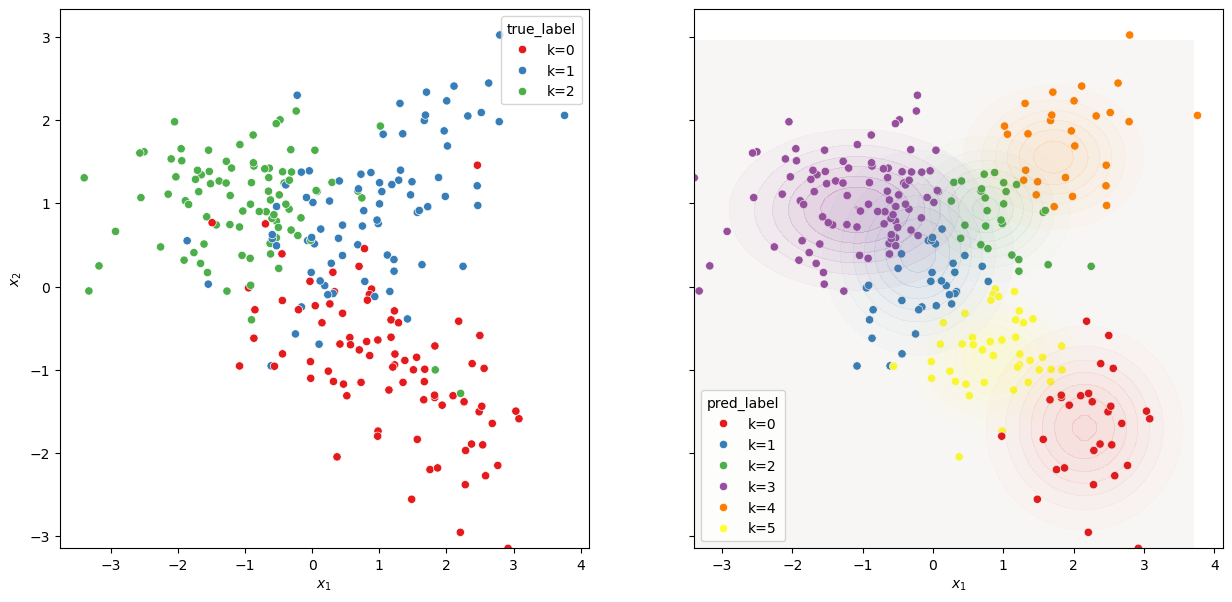

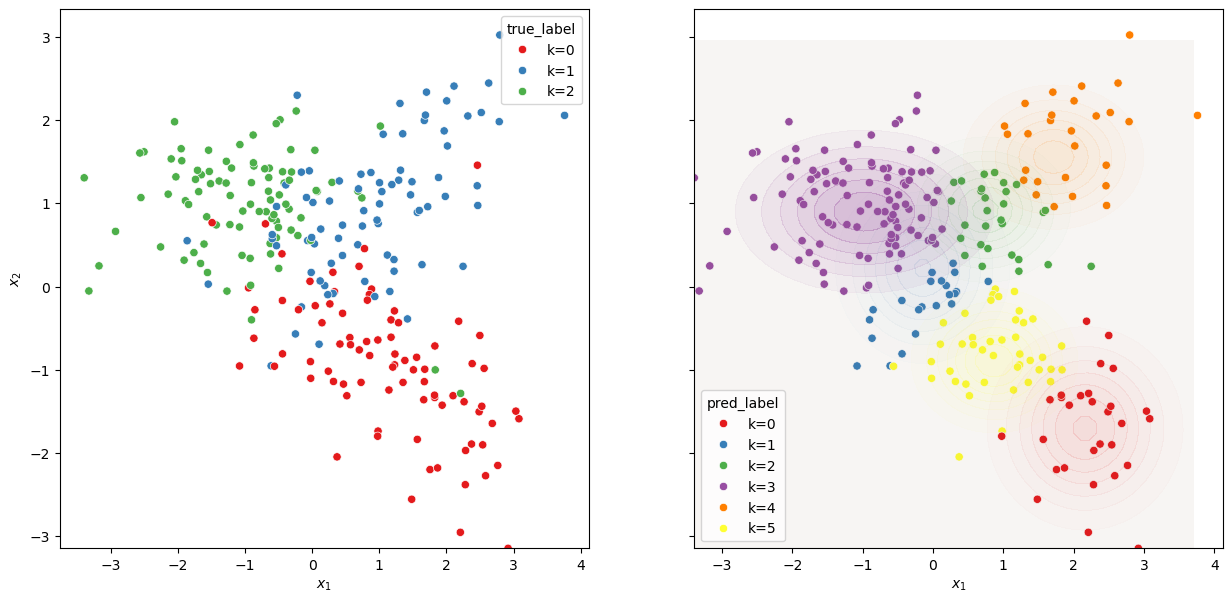

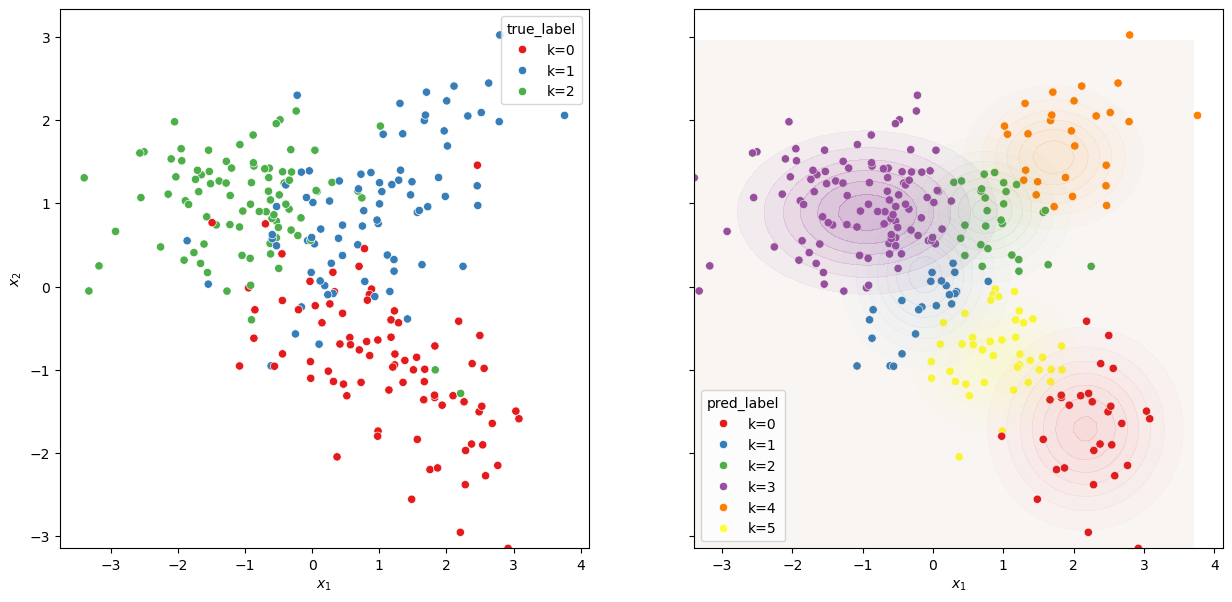

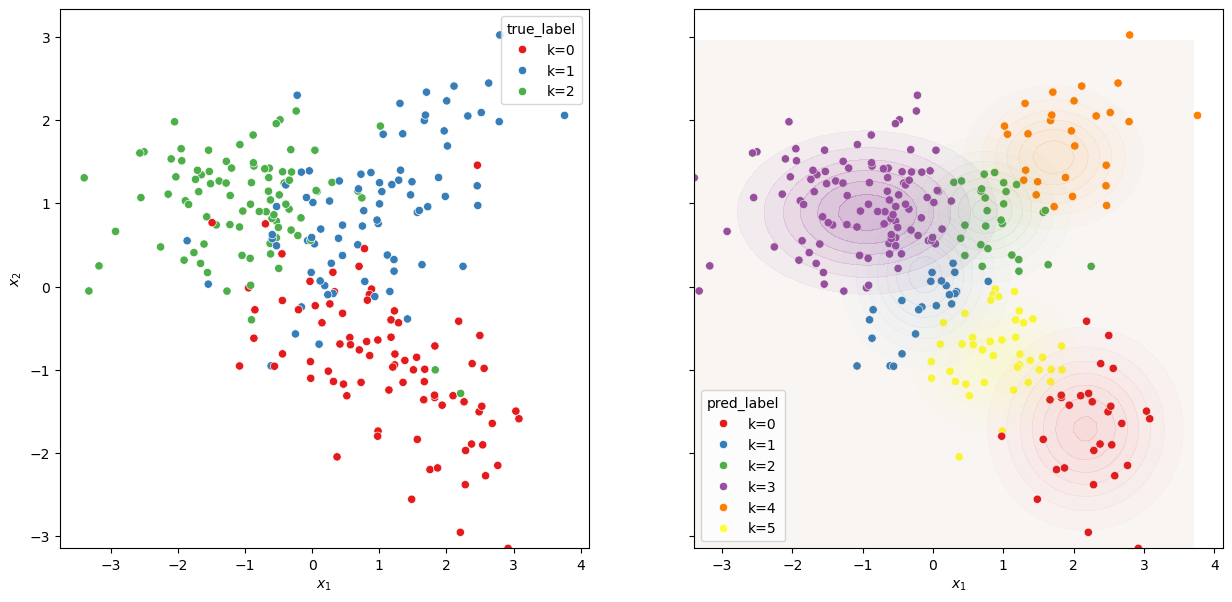

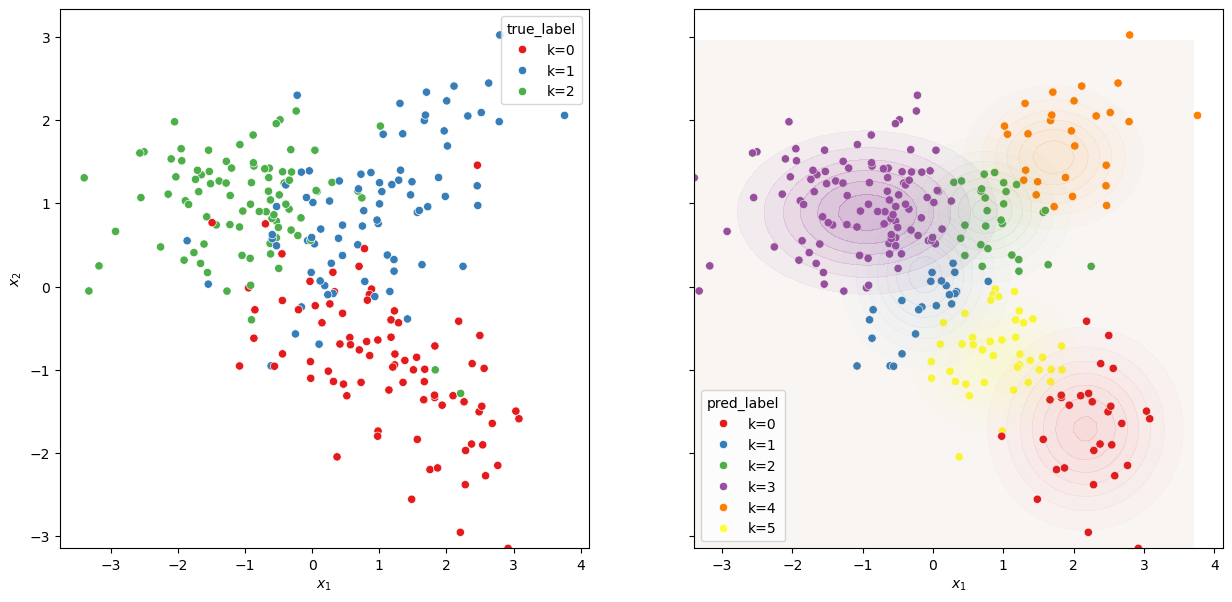

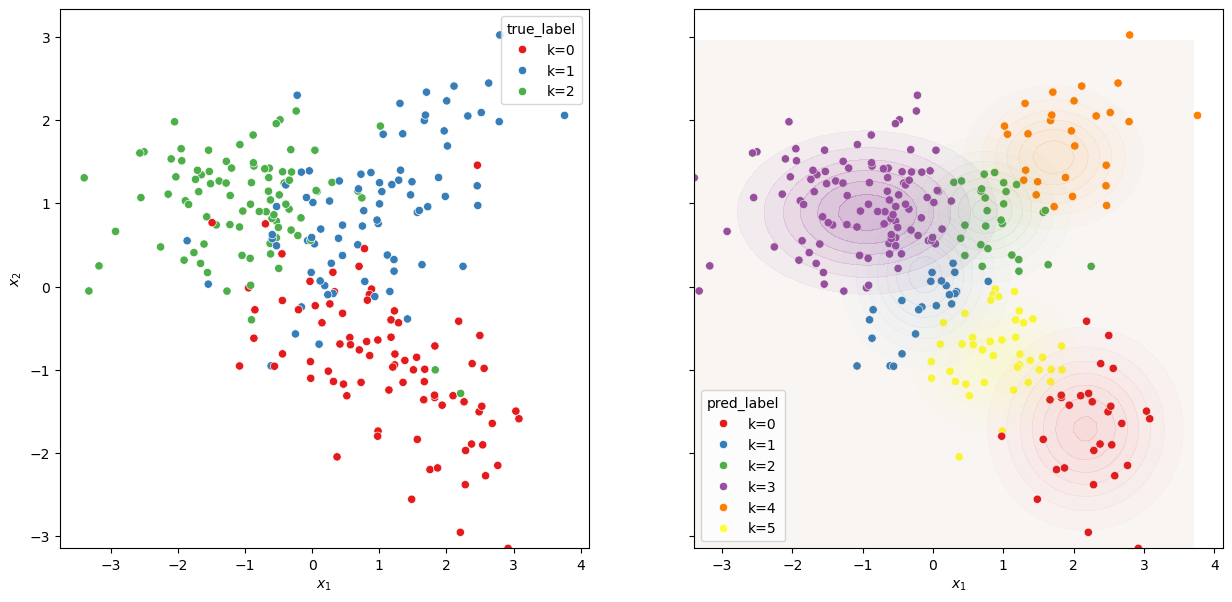

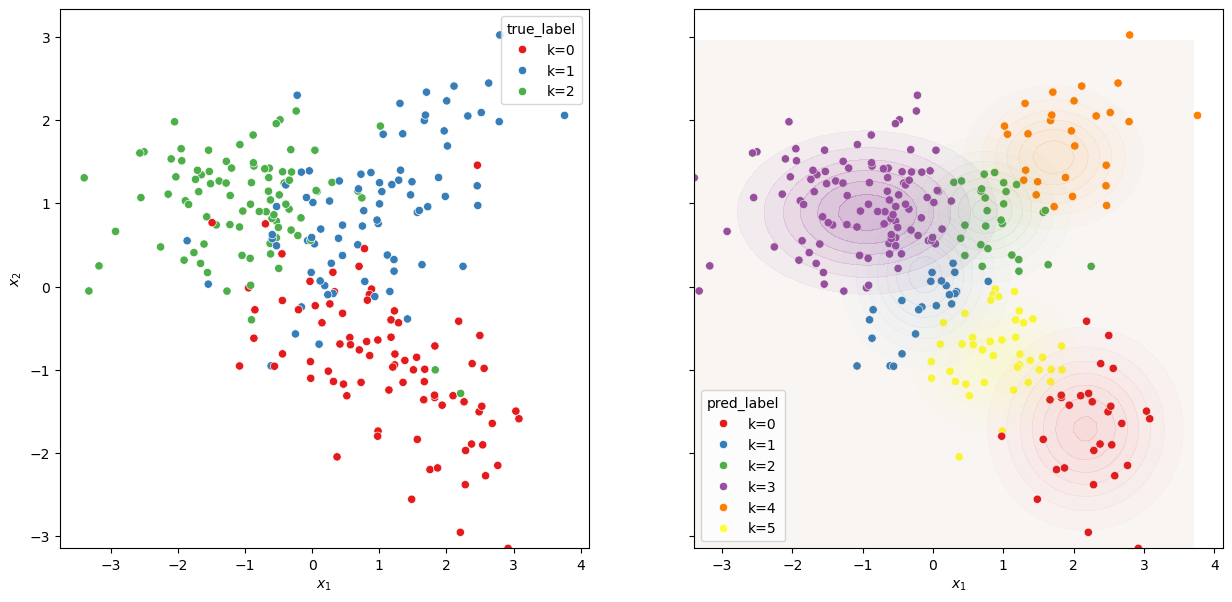

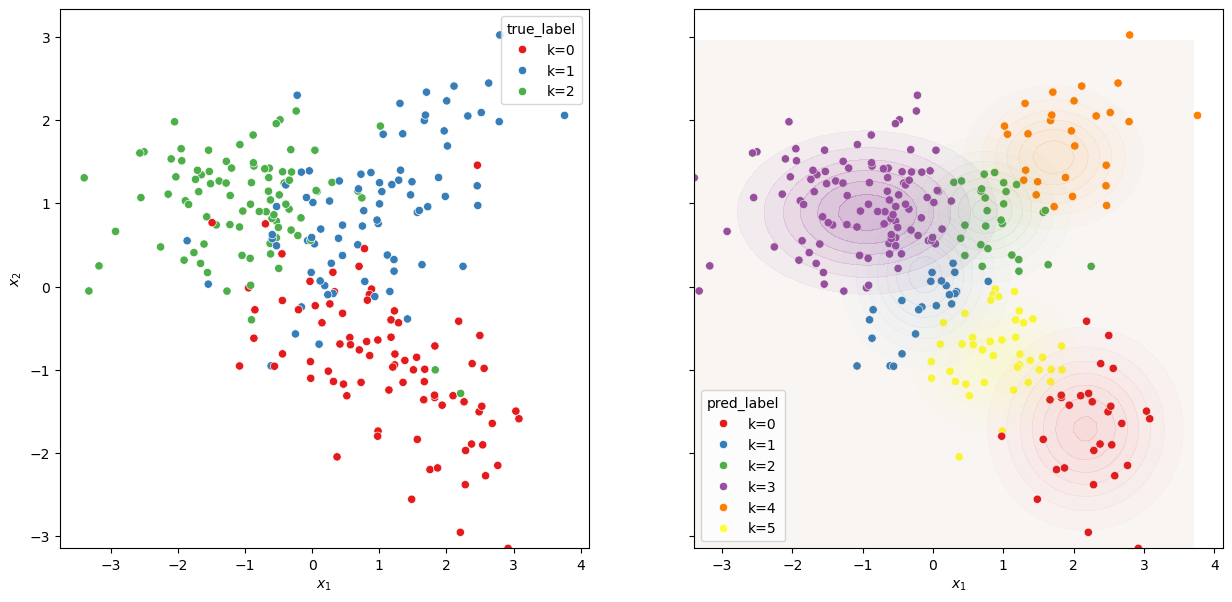

In [34]:
for max_steps in range(1, 1000, 100):
    plot_prediction(get_fitted_bayesian_estimator(data, 6, 'diag', max_steps, None, 'kmeans'))
plt.show()

#### Play around with the parameters. How does the prior influence the result? What happens for random initializations?

In [35]:
# ...